In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sc
from sklearn.metrics import r2_score
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy

np.set_printoptions(suppress=True)
ROOT.ROOT.EnableImplicitMT()

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Welcome to JupyROOT 6.28/00


In [2]:
date = "JUN29"

chain = ROOT.TChain("events")
chain.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1039_GFcat_Phi3Cat_2018.root".format(date))


1

In [3]:
df_SGN = ROOT.RDataFrame(chain)
df_SGN = df_SGN.Define("scale", "w*lumiIntegrated")\
            .Define("goodMeson_ditrk_mass_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[3]")\
            .Define("goodMeson_ditrk_eta_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[1]")\
            .Define("goodMeson_ditrk_phi_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[2]")\
            .Define("goodMeson_ditrk_pt_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[0]")\
            .Define("goodMeson_leadtrk_pt_GEN", "getMaximum(getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, 211, 333, 25), getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, -211, 333, 25))")\
            .Define("goodMeson_subleadtrk_pt_GEN", "getMinimum(getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, 211, 333, 25), getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, -211, 333, 25))")\
            .Define("goodPhotons_pt_GEN", "getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, 22, 25)")\
            .Define("goodMeson_DR_GEN", "getDR(GenPart_eta, GenPart_phi, GenPart_pdgId, GenPart_genPartIdxMother, -211, 333, 25, 211, 333, 25)")\
            .Define("goodMeson_mass_GEN", "get3BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 111, 333, 25)[3]")\
            .Define("goodMeson_pt_GEN", "get3BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 111, 333, 25)[0]")\
            .Define("HCandMass_GEN", "getHiggsPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, 333, 25, 22, 25)[3]")\
            .Define("HCandMassMissing", "compute_HiggsVars_var(goodMeson_ditrk_pt[0],goodMeson_ditrk_eta[0],goodMeson_ditrk_phi[0],goodMeson_ditrk_mass[0],photon_pt,goodPhotons_eta[index_pair[1]],goodPhotons_phi[index_pair[1]],0)")\
            .Define("HCandMassMissing_GEN", "getHiggsPtEtaPhiMPhi3Ditrack(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother)[3]")\
            .Define("goodMeson_ditrk_pt_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).Pt()")\
            .Define("goodMeson_ditrk_eta_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).Eta()")\
            .Define("goodMeson_ditrk_phi_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).Phi()")\
            .Define("goodMeson_ditrk_mass_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).M()")\
            .Define("Diff_pt_original", "(goodMeson_ditrk_pt[0]-goodMeson_ditrk_pt_GEN)/goodMeson_ditrk_pt_GEN")\
            .Define("Diff_pt_sum", "(goodMeson_ditrk_pt_sum-goodMeson_ditrk_pt_GEN)/goodMeson_ditrk_pt_GEN")\
            .Define("Diff_eta_original", "(goodMeson_ditrk_eta[0]-goodMeson_ditrk_eta_GEN)/goodMeson_ditrk_eta_GEN")\
            .Define("Diff_eta_sum",     "(goodMeson_ditrk_eta_sum-goodMeson_ditrk_eta_GEN)/goodMeson_ditrk_eta_GEN")\
            .Define("Diff_phi_original", "(goodMeson_ditrk_phi[0]-goodMeson_ditrk_phi_GEN)/goodMeson_ditrk_phi_GEN")\
            .Define("Diff_phi_sum",     "(goodMeson_ditrk_phi_sum-goodMeson_ditrk_phi_GEN)/goodMeson_ditrk_phi_GEN")\
            .Define("Diff_mass_original", "(goodMeson_ditrk_mass[0]-goodMeson_ditrk_mass_GEN)/goodMeson_ditrk_mass_GEN")\
            .Define("Diff_mass_sum",     "(goodMeson_ditrk_mass_sum-goodMeson_ditrk_mass_GEN)/goodMeson_ditrk_mass_GEN")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


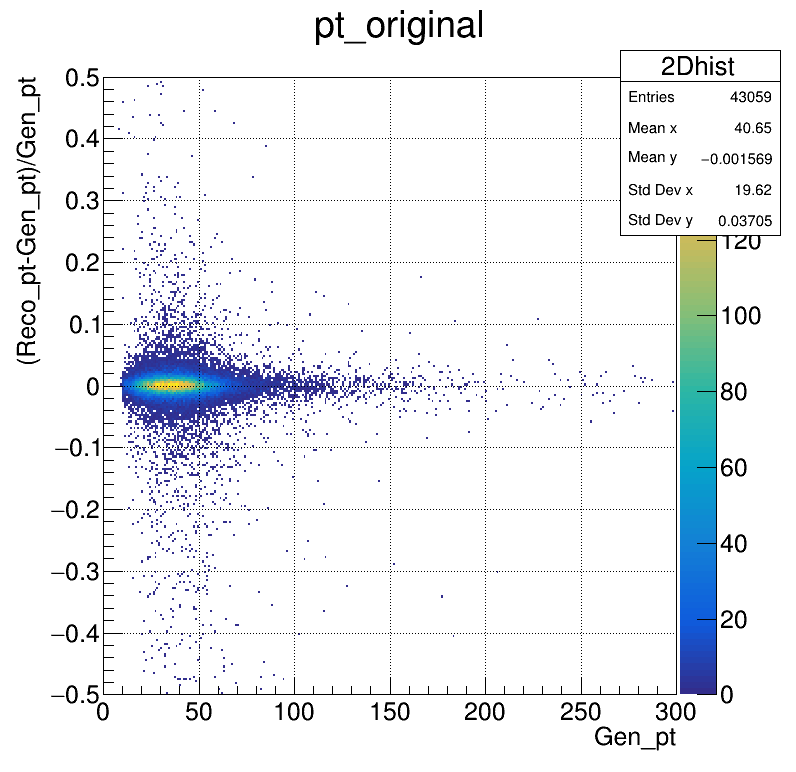

In [27]:
canvas = ROOT.TCanvas("canvas", "canvas", 800, 800)

nbins, xlow, xhigh, ylow, yhigh = 300, 0, 300, -0.5, 0.5

var = "pt"
meth = "original"

h = df_SGN.Histo2D(("2Dhist", var + "_" + meth, nbins, xlow, xhigh, nbins, ylow, yhigh), "goodMeson_ditrk_{}_GEN".format(var), "Diff_{}_{}".format(var, meth))

h.GetXaxis().SetTitle("Gen_{0}".format(var))
h.GetYaxis().SetTitle("(Reco_{0}-Gen_{0})/Gen_{0}".format(var))
h.GetZaxis().SetTitle("Events")
canvas.SetRightMargin(0.15)
canvas.SetLeftMargin(0.13)

h.SetContour(100)
h.Draw("colz")
canvas.SetGrid()

canvas.Draw()


In [135]:
filt = "(abs(goodMeson_ditrk_pt_GEN-goodMeson_ditrk_pt[0])<12.5 & abs(goodMeson_ditrk_eta_GEN-goodMeson_ditrk_eta[0])<0.0038 & abs(goodMeson_ditrk_phi_GEN-goodMeson_ditrk_phi[0])<0.00493 & abs(goodMeson_ditrk_mass_GEN-goodMeson_ditrk_mass[0])<0.151)"
#pt<12.5 for 1% rejection
#eta<0.0038 for 1% rejection
#phi<0.00493 for 1% rejection
#mass<0.151 for 1% rejection
df_filt = df_SGN.Filter(filt)
df_reje = df_SGN.Filter("!"+filt)

(42243,) (42243,)
(816,) (816,)
1.931680988566153 0.931680988566153


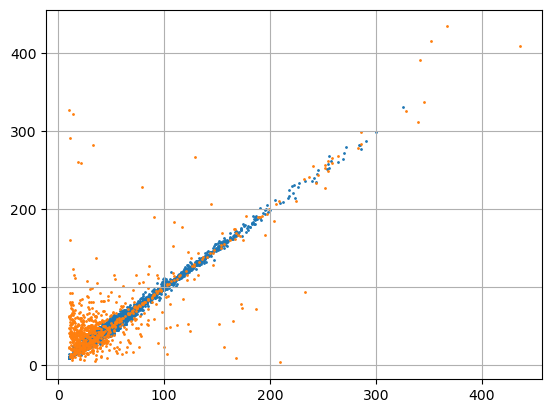

In [136]:
def getRSME(reco, gen):
    err = ((reco-gen)/gen)
    #return np.sum(np.abs(err))/len(err)
    return np.sqrt(np.sum(err**2)/len(err))

var = "pt"

cols = ["goodMeson_ditrk_{}_GEN".format(var), "goodMeson_ditrk_{}".format(var)]
x = df_filt.AsNumpy(columns=cols)
pddf = pd.DataFrame(x)

gen_filt = pddf["goodMeson_ditrk_{}_GEN".format(var)].to_numpy()
reco_filt = np.asarray([x[0] for x in pddf["goodMeson_ditrk_{}".format(var)]])
print(gen_filt.shape, reco_filt.shape)

x = df_reje.AsNumpy(columns=cols)
pddf = pd.DataFrame(x)

gen_reje = pddf["goodMeson_ditrk_{}_GEN".format(var)].to_numpy()
reco_reje = np.asarray([x[0] for x in pddf["goodMeson_ditrk_{}".format(var)]])
print(gen_reje.shape, reco_reje.shape)

print(len(gen_reje)/len(gen_filt)*100, abs(len(gen_reje)/len(gen_filt)*100 - 1))

plt.scatter(reco_filt, gen_filt, s=1)
plt.scatter(reco_reje, gen_reje, s=1)
plt.grid()
plt.show()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


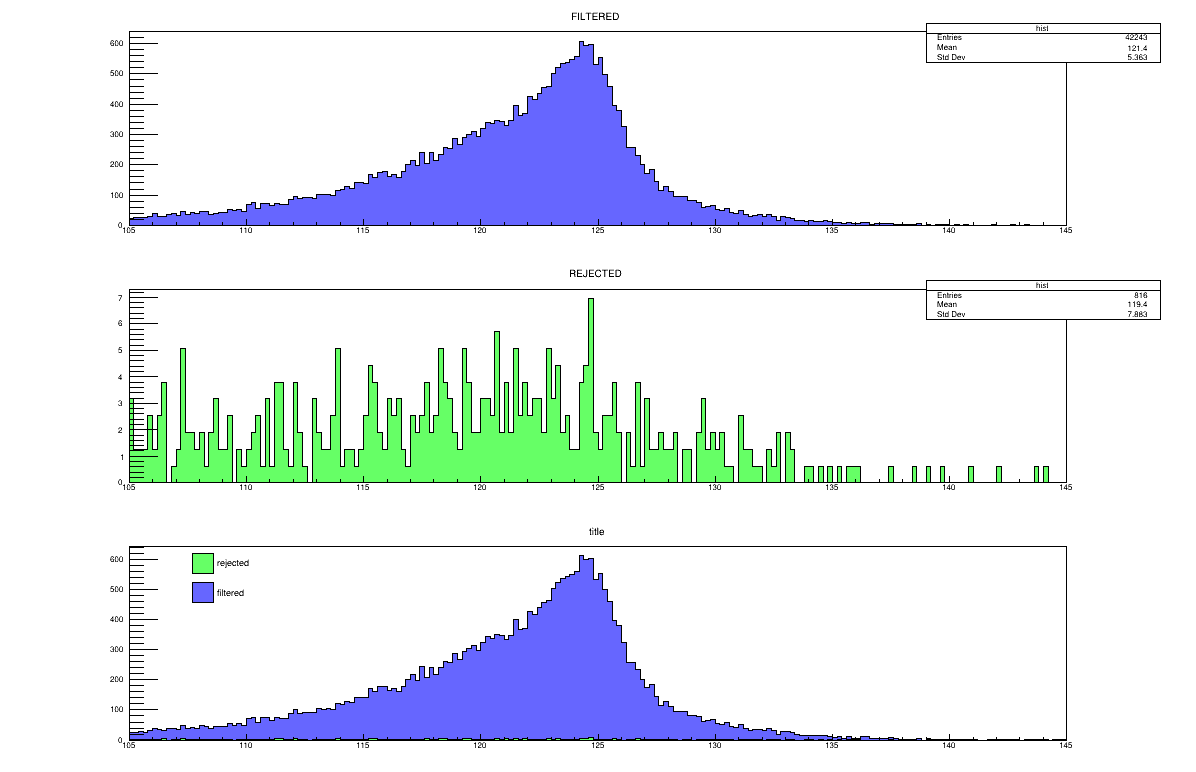

In [144]:
canvas = ROOT.TCanvas("canvas", "canvas", 1200, 800)
canvas.Divide(1, 3)
bins, xlow, xhigh = 200, 105, 145
var = "HCandMass"

h_filt=df_filt.Histo1D(("hist", "FILTERED", bins, xlow, xhigh), var, "scale")

h_reje=df_reje.Histo1D(("hist", "REJECTED", bins, xlow, xhigh), var, "scale")

h_filt.SetFillColor(ROOT.kBlue-7)
h_filt.SetLineColor(ROOT.kBlack)
h_reje.SetFillColor(ROOT.kGreen-7)
h_reje.SetLineColor(ROOT.kBlack)

canvas.cd(1)
h_filt.Draw("hist")
canvas.cd(2)
h_reje.Draw("hist")

canvas.cd(3)
stack = ROOT.THStack("stack", "title")
stack.Add(h_reje.GetValue())
stack.Add(h_filt.GetValue())
stack.Draw("hist")
#stack.GetXaxis().SetTitle("p_{T}_{2trk}^{#phi#rightarrow #pi#pi} [GeV]")
#stack.GetYaxis().SetTitle("Frequency")

legend = ROOT.TLegend(0.15, 0.65, 0.3, 0.89)
legend.SetMargin(0.17)
legend.SetBorderSize(0)
legend.SetTextSize(0.04)
legend.AddEntry(h_reje.GetValue(), "rejected", "f")
legend.AddEntry(h_filt.GetValue(), "filtered", "f")
legend.Draw()

canvas.Draw()

In [7]:
cols = ["goodMeson_ditrk_pt_GEN", "goodMeson_ditrk_pt", "goodMeson_ditrk_eta", "goodMeson_ditrk_phi", "goodMeson_ditrk_mass", "goodPhotons_pt", "goodPhotons_eta", "goodPhotons_phi"]
x = df_SGN.AsNumpy(columns=cols)
pddf = pd.DataFrame(x)
for e in cols[1:]:
    pddf[e] = pddf[e].apply(lambda vec: vec[0])
    
display(pddf)

y = pddf.to_numpy()[:,0]
X = pddf.to_numpy()[:,1:]

print(len(X), len(y))
print(type(X), type(y))
print(X.shape, y.shape)
print(X[0], y[0])

,goodMeson_ditrk_pt_GEN,goodMeson_ditrk_pt,goodMeson_ditrk_eta,goodMeson_ditrk_phi,goodMeson_ditrk_mass,goodPhotons_pt,goodPhotons_eta,goodPhotons_phi
0,47.187481,47.452663,0.203295,3.139808,0.664158,63.222118,0.238861,0.075485
1,29.466137,29.243576,0.222465,1.543458,0.602808,61.592999,-0.084076,-1.477295
2,54.356922,53.977764,-0.731066,-1.555236,0.647808,56.625488,-0.155792,1.581787
3,32.935303,32.778759,-1.205343,-2.378436,0.453156,42.456753,0.124237,0.490662
4,40.432590,40.665890,-0.343606,-2.015512,0.643010,49.229046,0.155518,1.085205
...,...,...,...,...,...,...,...,...
43054,27.779606,27.943230,-0.279498,-1.104404,0.621867,67.521408,1.189209,0.092545
43055,24.124313,23.678562,1.597529,-2.465838,0.399245,62.703606,0.126923,1.034180
43056,45.998840,46.301582,1.291496,2.300698,0.778696,62.928493,0.983643,-0.983521
43057,91.999878,92.313522,1.351210,-0.317169,0.482550,39.080238,0.591553,-2.299316


43059 43059
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(43059, 7) (43059,)
[47.45266342  0.20329477  3.1398077   0.66415787 63.22211838  0.23886108
  0.07548523] 47.18748092651367


In [145]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True)

# Before we convert data into tensors, we standarize the data (to (x-mu)/sigma)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
# y are to be reshaped to (-1, 1), i.e., transposed
print(X_train, type(X_train), X_train.shape)
X_train = torch.tensor(X_train, dtype=torch.float32)
#print(y_train, type(y_train), y_train.shape)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
#print(y_train, type(y_train), y_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

[[-0.30815443  2.13671057 -0.8741536  ... -0.86283863  0.31593939
   0.69984412]
 [ 0.41234609  1.34230259  0.06739018 ... -0.13110229  0.85939269
  -1.73010652]
 [-0.93744692  0.59374184  1.02352654 ... -0.21350814  0.05966582
  -0.67534172]
 ...
 [-0.11299776  1.60856795  0.22149623 ... -0.70823553  0.21999851
  -1.32165172]
 [-0.32262872 -1.49303991  1.36533381 ... -0.50161883 -0.92481549
  -0.40173988]
 [ 0.15902468 -0.86928993  0.23768534 ...  0.15673113 -0.43565037
  -1.55567937]] <class 'numpy.ndarray'> (25835, 7)


In [151]:
# Define the model. It has N layers
# Start with 7 features
# End with 1, we only want to predict one value
# Usually we go from big and we decrease the size of the layers
model = nn.Sequential(
    nn.Linear(7, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
)

In [171]:
# Define loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#print(loss_fn)
#print(optimizer)

In [153]:
history = []

In [172]:
n_epochs = 50   # number of epochs to run
batch_size = 10000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None


for epoch in tqdm.tqdm(range(n_epochs)):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=1.0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
        print(epoch, best_mse)

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))

  2%|▏         | 1/50 [00:01<00:56,  1.16s/it]

0 25.677715301513672


  4%|▍         | 2/50 [00:02<00:51,  1.07s/it]

1 25.669357299804688


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

MSE: 25.67
RMSE: 5.07


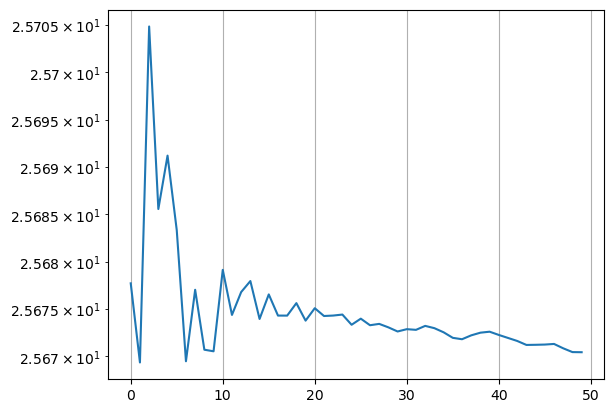

In [175]:
plt.plot(history[170:])
plt.grid()
plt.yscale('log')
plt.show()

In [176]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print("Prediction: {:.4f}, Reco: {:.4f}, Gen: {:.4f}".format(np.round(y_pred[0].numpy()[0], 4), round(X_test_raw[i,0], 4), np.round(y_test[i].numpy()[0], 4)))

with torch.no_grad():
    X_sample = torch.tensor(scaler.transform(X_test_raw), dtype=torch.float32)
    y_pred = model(X_sample)
    gen = y_test.numpy().flatten()
    reco = X_test_raw[:,0]
    pred = y_pred.numpy().flatten()
    print(getRSME(reco, gen))
    print(getRSME(pred, gen))

Prediction: 45.4058, Reco: 45.4453, Gen: 45.2969
Prediction: 33.6592, Reco: 34.1055, Gen: 34.6239
Prediction: 43.8104, Reco: 43.7188, Gen: 42.6562
Prediction: 36.9493, Reco: 36.6562, Gen: 36.5935
Prediction: 16.1357, Reco: 12.9335, Gen: 12.5152
0.10698676846212107
0.11338343977411554
